Source: https://github.com/mommermi/geotiff_sample

![Sample](https://github.com/mommermi/geotiff_sample/raw/master/sample.png)

### Install Spatial-Utils library 
Bring utility functions to deal with raster data and visualization

In [0]:
%pip install -U "databricks-spatial[raster] @ git+https://github.com/databrickslabs/mosaic.git@spatial-utils-v1" --quiet


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
petastorm 0.12.1 requires pyspark>=2.1.0, which is not installed.
numba 0.57.1 requires numpy<1.25,>=1.21, but you have numpy 1.26.4 which is incompatible.
ydata-profiling 4.5.1 requires numpy<1.24,>=1.16.0, but you have numpy 1.26.4 which is incompatible.
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
dbutils.library.restartPython()

In [0]:
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio

from rasterio.plot import show as rasterio_show


In [0]:
# SPATIAL-UTILS @ UTILS
from spatial import Utils

# SPATIAL-UTILS @ VIZ
from spatial.viz.helpers import *

# SPATIAL-UTILS @ RASTER
# - registers UDFs
# - provides PolarsUtils and RioUtils
from spatial.raster import *

# SPATIAL-UTILS @ H3
# - provides H3Utils
from spatial.grid.h3 import *


In [0]:
from pyspark.sql import functions as F
from pyspark.sql.functions import udf, col
from pyspark.sql.types import *


In [0]:
%sql
USE CATALOG mpelletier;
CREATE DATABASE IF NOT EXISTS geospatial;
CREATE VOLUME IF NOT EXISTS geospatial.input;

In [0]:
%python
dbutils.fs.mkdirs("/Volumes/mpelletier/geospatial/input/data_raw")
dbutils.fs.mkdirs("/Volumes/mpelletier/geospatial/input/data_div")
dbutils.fs.cp("file:/Workspace/Users/mathieu.pelletier@databricks.com/geotiff-ml/sample.tif", "/Volumes/mpelletier/geospatial/input/data_raw")

True

In [0]:
dir_in = "/Volumes/mpelletier/geospatial/input/data_raw/"
df_in = spark.createDataFrame(dbutils.fs.ls(dir_in))
df_in = df_in.withColumn("path_div",  F.lit("/Volumes/mpelletier/geospatial/input/data_div"))
df_in.display()


path,name,size,modificationTime,path_div
dbfs:/Volumes/mpelletier/geospatial/input/data_raw/sample.tif,sample.tif,6018396,1746730010000,/Volumes/mpelletier/geospatial/input/data_div


### Subdivide original file (<1mb)

In [0]:
spark.catalog.clearCache()

df_out = (df_in
    .select(subdivide_tif_mb_udf("path", "path_div", F.lit(1)))  # <- SPATIAL-UTILS
    .cache())
display(df_out)

"subdivide_tif_mb_udf(path, path_div, 1)"
"List(/Volumes/mpelletier/geospatial/input/data_div/sample-0_0.tif, /Volumes/mpelletier/geospatial/input/data_div/sample-0_1.tif, /Volumes/mpelletier/geospatial/input/data_div/sample-0_2.tif, /Volumes/mpelletier/geospatial/input/data_div/sample-1_0.tif, /Volumes/mpelletier/geospatial/input/data_div/sample-1_1.tif, /Volumes/mpelletier/geospatial/input/data_div/sample-1_2.tif, /Volumes/mpelletier/geospatial/input/data_div/sample-2_0.tif, /Volumes/mpelletier/geospatial/input/data_div/sample-2_1.tif, /Volumes/mpelletier/geospatial/input/data_div/sample-2_2.tif)"


In [0]:
ds_4326 = rasterio.open(f"/Volumes/mpelletier/geospatial/input/data_div/sample-2_2.tif")
print(f"bounds -> {ds_4326.bounds}")
print(f"bands -> {ds_4326.count}")
print(f"shape -> {ds_4326.shape}")
print(f"meta -> {ds_4326.meta}")

bounds -> BoundingBox(left=597200.0, bottom=5780620.0, right=600530.0, top=5783950.0)
bands -> 3
shape -> (333, 333)
meta -> {'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 333, 'height': 333, 'count': 3, 'crs': CRS.from_epsg(32631), 'transform': Affine(10.0, 0.0, 597200.0,
       0.0, -10.0, 5783950.0)}


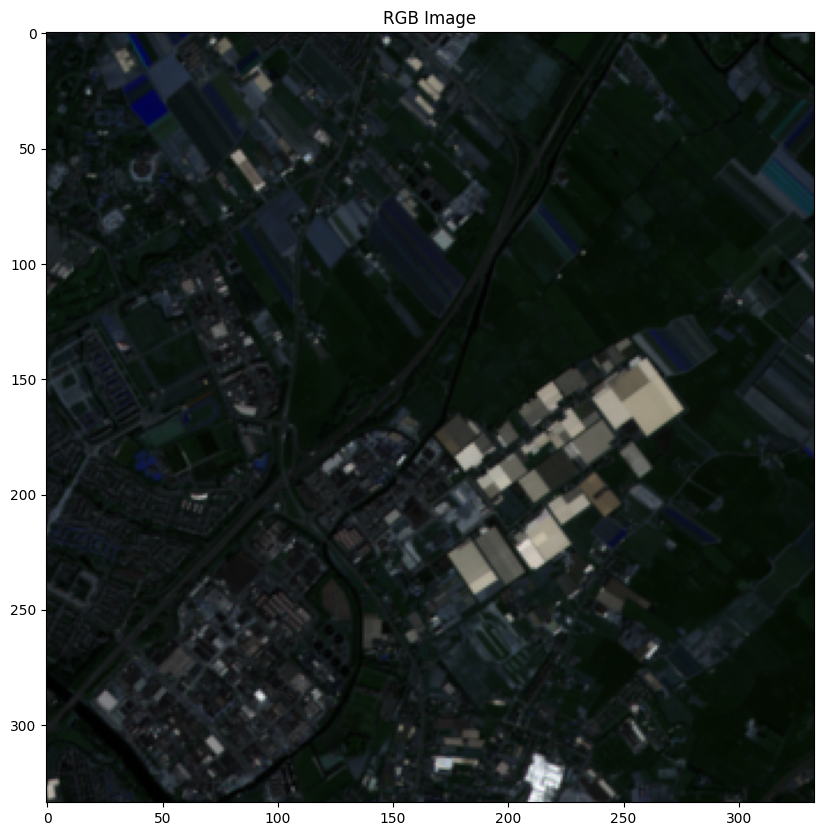

In [0]:
import matplotlib.pyplot as plt
import rasterio
import numpy as np

# Open the TIFF file
ds_4326 = rasterio.open("/Volumes/mpelletier/geospatial/input/data_div/sample-2_1.tif")

# Read the three bands (assuming the file has at least 3 bands)
band1 = ds_4326.read(1)
band2 = ds_4326.read(2)
band3 = ds_4326.read(3)

def normalize(array):
    array_min, array_max = array.min(), array.max()
    return ((array - array_min) / (array_max - array_min) * 255).astype(np.uint8)

rgb_image = np.dstack((
    normalize(band1),
    normalize(band2),
    normalize(band3)
))

# Plot the RGB image
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(rgb_image)  # Use ax.imshow instead of show
ax.set_title("RGB Image")
plt.show()

### Read tiles in binary format

In [0]:
df = spark.read.format("binaryFile").load("/Volumes/mpelletier/geospatial/input/data_div/")
df.display()

path,modificationTime,length,content
dbfs:/Volumes/mpelletier/geospatial/input/data_div/sample-0_0.tif,2025-05-07T15:32:48Z,670224,"List(SUkqAAgAAAAQAAABAwABAAAATgEAAAEBAwABAAAATgEAAAIBAwADAAAAzgAAAAMBAwABAAAAAQAAAAYBAwABAAAAAQAAABEBBABUAAAAfAEAABUBAwABAAAAAwAAABYBAwABAAAABAAAABcBAwBUAAAA1AAAABwBAwABAAAAAQA= (truncated), null)"
dbfs:/Volumes/mpelletier/geospatial/input/data_div/sample-0_1.tif,2025-05-07T15:32:49Z,670224,"List(SUkqAAgAAAAQAAABAwABAAAATgEAAAEBAwABAAAATgEAAAIBAwADAAAAzgAAAAMBAwABAAAAAQAAAAYBAwABAAAAAQAAABEBBABUAAAAfAEAABUBAwABAAAAAwAAABYBAwABAAAABAAAABcBAwBUAAAA1AAAABwBAwABAAAAAQA= (truncated), null)"
dbfs:/Volumes/mpelletier/geospatial/input/data_div/sample-1_0.tif,2025-05-07T15:32:51Z,670224,"List(SUkqAAgAAAAQAAABAwABAAAATgEAAAEBAwABAAAATgEAAAIBAwADAAAAzgAAAAMBAwABAAAAAQAAAAYBAwABAAAAAQAAABEBBABUAAAAfAEAABUBAwABAAAAAwAAABYBAwABAAAABAAAABcBAwBUAAAA1AAAABwBAwABAAAAAQA= (truncated), null)"
dbfs:/Volumes/mpelletier/geospatial/input/data_div/sample-1_1.tif,2025-05-07T15:32:51Z,670224,"List(SUkqAAgAAAAQAAABAwABAAAATgEAAAEBAwABAAAATgEAAAIBAwADAAAAzgAAAAMBAwABAAAAAQAAAAYBAwABAAAAAQAAABEBBABUAAAAfAEAABUBAwABAAAAAwAAABYBAwABAAAABAAAABcBAwBUAAAA1AAAABwBAwABAAAAAQA= (truncated), null)"
dbfs:/Volumes/mpelletier/geospatial/input/data_div/sample-0_2.tif,2025-05-07T15:32:50Z,668220,"List(SUkqAAgAAAAQAAABAwABAAAATgEAAAEBAwABAAAATQEAAAIBAwADAAAAzgAAAAMBAwABAAAAAQAAAAYBAwABAAAAAQAAABEBBABUAAAAfAEAABUBAwABAAAAAwAAABYBAwABAAAABAAAABcBAwBUAAAA1AAAABwBAwABAAAAAQA= (truncated), null)"
dbfs:/Volumes/mpelletier/geospatial/input/data_div/sample-1_2.tif,2025-05-07T15:32:52Z,668220,"List(SUkqAAgAAAAQAAABAwABAAAATgEAAAEBAwABAAAATQEAAAIBAwADAAAAzgAAAAMBAwABAAAAAQAAAAYBAwABAAAAAQAAABEBBABUAAAAfAEAABUBAwABAAAAAwAAABYBAwABAAAABAAAABcBAwBUAAAA1AAAABwBAwABAAAAAQA= (truncated), null)"
dbfs:/Volumes/mpelletier/geospatial/input/data_div/sample-2_0.tif,2025-05-07T15:32:52Z,668220,"List(SUkqAAgAAAAQAAABAwABAAAATQEAAAEBAwABAAAATgEAAAIBAwADAAAAzgAAAAMBAwABAAAAAQAAAAYBAwABAAAAAQAAABEBBABUAAAAfAEAABUBAwABAAAAAwAAABYBAwABAAAABAAAABcBAwBUAAAA1AAAABwBAwABAAAAAQA= (truncated), null)"
dbfs:/Volumes/mpelletier/geospatial/input/data_div/sample-2_1.tif,2025-05-07T15:32:53Z,668220,"List(SUkqAAgAAAAQAAABAwABAAAATQEAAAEBAwABAAAATgEAAAIBAwADAAAAzgAAAAMBAwABAAAAAQAAAAYBAwABAAAAAQAAABEBBABUAAAAfAEAABUBAwABAAAAAwAAABYBAwABAAAABAAAABcBAwBUAAAA1AAAABwBAwABAAAAAQA= (truncated), null)"
dbfs:/Volumes/mpelletier/geospatial/input/data_div/sample-2_2.tif,2025-05-07T15:32:54Z,666222,"List(SUkqAAgAAAAQAAABAwABAAAATQEAAAEBAwABAAAATQEAAAIBAwADAAAAzgAAAAMBAwABAAAAAQAAAAYBAwABAAAAAQAAABEBBABUAAAAfAEAABUBAwABAAAAAwAAABYBAwABAAAABAAAABcBAwBUAAAA1AAAABwBAwABAAAAAQA= (truncated), null)"


### Convert 3 bands (R,G,B) to PNG image

In [0]:
import pandas as pd
import numpy as np
import rasterio
import io
from PIL import Image

from pyspark.sql.functions import pandas_udf
from pyspark.sql.types import BinaryType

@pandas_udf(BinaryType())
def geotiff_to_png(content_series: pd.Series) -> pd.Series:
    results = []
    for binary_data in content_series:
        try:
            # Read GeoTIFF from binary
            with rasterio.MemoryFile(io.BytesIO(binary_data)) as memfile:
                with memfile.open() as dataset:
                    # Read all bands
                    bands = [dataset.read(i + 1).astype(np.float32) for i in range(dataset.count)]
                    
                    # Normalize pixel values to 0–255 for PNG
                    min_val = np.nanmin(bands)
                    max_val = np.nanmax(bands)
                    if max_val - min_val == 0:
                        scaled_bands = [np.zeros_like(band, dtype=np.uint8) for band in bands]
                    else:
                        scaled_bands = [((band - min_val) / (max_val - min_val) * 255).astype(np.uint8) for band in bands]
                    
                    # Stack bands to create an RGB image
                    if len(scaled_bands) == 1:
                        rgb_image = np.stack([scaled_bands[0], scaled_bands[0], scaled_bands[0]], axis=-1)
                    else:
                        rgb_image = np.stack(scaled_bands[:3], axis=-1)
                    
                    # Create PIL image
                    img = Image.fromarray(rgb_image)

                    # Convert to PNG in memory
                    with io.BytesIO() as output:
                        img.save(output, format="PNG")
                        png_data = output.getvalue()
                    results.append(png_data)

        except Exception as e:
            print(f"Error converting image: {e}")
            results.append(None)
    return pd.Series(results)

# Apply the UDF to create a new column
decoded_df = df.withColumn("image", geotiff_to_png(df["content"]))

# Show the result
decoded_df.selectExpr("path", "modificationTime", "length", "image as content").write.mode("overwrite").saveAsTable("mpelletier.geospatial.tiff")

In [0]:
spark.read.table("mpelletier.geospatial.tiff").display()

path modificationTime length content dbfs:/Volumes/mpelletier/geospatial/input/data_div/sample-0_0.tif 2025-05-07T15:32:48Z 670224 List(iVBORw0KGgoAAAANSUhEUgAAAU4AAAFOCAIAAABmMWM+AAEAAElEQVR4nDT9S44kS5AsiomImrlnne57wa0RILgsguCyOCMXQryH7lMV4aYqwoFXDxMoZGV6epipypcA/r//r//7jB1uBCHYY4EAAi4zSgDKCieSPSVwypylcZg= (truncated), iVBORw0KGgoAAAANSUhEUgAAAGMAAABjCAIAAAAAWSnCAAA0UklEQVR42k2dC5Yb57Gkua97Lcl3djA2G0BVAehuUi97tjIjdeNRAPpBUpLt7ahRL6Ap72UyvsgCfQ4ODoguAFX5Z0ZGRuZffHP/7X+9/PTXl//7l99/+uvxp7fHn/7S/Hx1/Pnt8e6vL/H67m1zd9XcX/Wb2fF+0t5f8Zh0q0m7mcazDoiDf/5rc/fX9u6qXU26+3jz6hgv1kW7mjZx5P1En13F8bN+Uw6bWbee6cj4+P1Vczfp19N2Pe3WZXM3beLj8VhdxbfFl7f38Q0zfclqptdx/M9xPvGd0yMn1q71/fqJu7d65y5exPlfvejF5EUHXzWr+P5Zx+8O26LblnEanANnwq8f76ZHHVb024KDdVizmbV10e/mzaZ4s/n+T3GRYaCXn/738ee/cM36PV9DPMcZ6Jfu3r7EqdxPhk3RxBljQVltdcUFT7q7ia8krBwXE3/SZei3/X78dthi1t3Hs0wWpyLrjM9hrPjO+Krj/du4ANniTp+Ny+5k05m+CnNrneLa9KPT3isR52lbcM2c/9XLz7Jyy2/Fn3oZqNL1xy9uZs1WlorjZRcdEN8z7bb6U7zTx191vB59rX+GW7xZf/ff4Uov/+8tdpk0us7wDj17fbS2YQ6dpZZ6WM+8kvo6rdKEK9ef9AL30are4YAyaHicv0Qr3+j4Wb+WueVx9/lxe5B8WVeoY/TPu78ccas48kUeFCab2lhaSP7ZsEJhXz4rP4oDjvqGYqjlO8O2Ci8OcxzXpYxVF816mvERBtpg6/CsWK1NWKQ4xkXVZber2ro8xmnogDhs8mb17X+FQx0j9BxEP+naWvylu9d6hteEFRpbROuv5e3luvpnRGVEh9Zhg3vLR2IpZvhUXNVVywKEQeWJeJ/OkjU86pJkdH3//Vuer3CcDGG7BsGYUUkIy0305feTy0eONq4C7apfFce0adHYeeMk12GF0mjwot9lkbZFhBVvTnXO4ZLbMCiLIdsR9VgzzIdPXYLlLoNIsZAnLQcecNGO9x1QGUF2Bz+zSvrqgDm+SpchpLjg1OTlnj8pRgL1AhoMSXYEmab163s/9Fsd5sZqb7UkwpFAOsVsmz86bRL1pkLGWKc4ZlPEMQF8xJ2CLlaFhQyTEW5AUnhQq8jAm9ZxzAzbxTHh+3xt/AouFocFTv03yx52mcVq9OtS3iFXCrsUBry0yOqKAMwLG+KEAiB19nEGrHYgkV4Iofv1VS+DKqyOuENnhwdW5VlyE3zzngiV+1wp2O+JRPnd6MXr2ame90aWVVxehVGMSnnZcanGl2GNEfXNcaQ+AsrEn+adnF12kSHilGQgw7m+s93kxWqxw7/iEXEXcboWfsWXhE/9qQu4ZfV6GQvI5Prt85y9zrjxUsvFqrhsDFQMyiNVYxcziNjv7q8CHcIZ+5Vj1ovsrBf/LLlaHYYtCBa+H1eNX58OAYWKHTlgrF8ccApzhBcocPRzJ/204gss18WEvU7bSi/WgiecJYOrYdV1sMBIgNVup8SXkKjdkP4Eo/F6oneETZxhJP0w6Fa576tOCz51LnPQsXr4zt3Eq8eZ6Wr7TVyD3pEhdPH6uqMumL+uFURh+laEQLaGGWBQYVlkXK1wwzKw8rNzwOfKOVE26vhOoqzqndfDibZlZm4f4+XUahU+3uipUN04x5f54IAWZtCQdmQgrfcseEzjXOkXciIZPTzuhXeE5diorQPdqzebb4MlTLs7mSayeydPjmvGKcCCgZWUUbzaq+KkbFLqYuKSVkWaYCPTnCLdGEHklc7BV5c/Dbv5UMf1x9mH4aphOz8BOvGFp12FNfnmjb9EnzLlAXrCmoroBs/14mnlHTJxDN4d+Q7bld36S/pPVMJqULNIJuQNzGrYlueGReJ89nOd5646xamGY+7m8X5QqjebiD6wMCyla7ifEFOKGhlloxcDftT74o2XARwbMFKLL+NG7tBZeuWFdFor2WVbxk/GIwwRn4qgOO0Xnw/X54fbz4eb0355ruenXRxjZK0Ef7rC+JIK/jUhT8lkQ2AoPtXXJd5d2BzdpswAxL8ioOJXIvGFvQbcCp+CuMmV7Dgzkl1kOpBX7gafCrvXYR3ZyxSsFaXSO2+233/VAzEyBMlF63whAZfwWcNraxmR9wVkOl0ZItAhIl/YqZDhJEY/qhx6w4aHfjXcavH54d3psDzvFif9E9YDJMsKGTKz1hT/boqXkXZ1WOHzIYvbieYd9D0+clLamuGtC10enhILI2dZJQw16ySfR2dn4XdiudEqwlC0K855SxDsq1iYSH9v6h++0s+sQB+BReGwyqSzCacwPJXnHVEWb26r1/1csFXLKKS8eF2diGpfJ/jqbD2VKevqNeyyW5z31+fDMnwqLuCPeLFfvO5Hj5OheWY9xqJnaj86hYPI7o7NYEaFHIeQGXSS4QLyI2yhwqjnT3EywhrcPLLYUe5D4t+MyUc+5QPwIC5B3lDHo4oYDIeNb4g/hU99Le/Q9cs1HG7xQhdGNklLZU0gvwgMfiVth0cIfbacFtbUVcndJk5YAxERhgj3Oe/mHD+PF+ed7HU+XL/ulqdYN1mnGpJPF2awBrXXw40SvJahgnArfvttslxHXJxhfC1RX4LcGWLglCxl6yiNRGkpU050APRK5ykk0mWaN0Q8QuUDxcW29Kedips39Y/fgEozMpoi5bQ1KCraHQ5x5V6i8KNeOa48c/GneiEwtiM4Z62mNuWpLs5g0Hk/15H7Mh0nTksmW4Q32YICr3qOpebhHYCav0GxfH7AmmMe4GHUhzeC02RSIbqAqeZ9s0fQ58WYvbo6wsKA87ccEya7OpIKwiIyXxLOabMFCg/zgKdw8LDgsF8Ip4LORV6XLSi4ewegSICBUyTF0RHvsLYqqV7lJpWsHMaK7xVazYkvfGcHeNdKavHAIpVQaaf0xMfzT8Z7YcGWP8kHAx3msqw/EubG1+LLbRdd8P2scV6zJLDK8khlIIoFTHUKeFOBb0vAm9oj0vG2yEjEOuEyx/WX100th22Apz5waqcojtz3lRltbxpCjhN7kgsIL8MLYgXOeiYo7PBe4VUxgovc5LxfxEfClV7DX/bL+KCsJtcrzzpv2VQmA2uwUQYvbhh/mstbd0JAoXJtXFsOa4UeMKzgMllvsiKZubIb6bXUC5OvI7n/mNakxoyH/CiS+9TFsLiSIzE+jmfpHf26cKqphQPhUFEtRzBG9P05sOm8teO4/oYcAWxJGo3NWnYBWUthPOhPgidchsvWc0ScYlO+YBFDTF2hpOjeGllIgiN7IvoqaEeBW8nW4ZLn2jle4AUYWRhIy7au9QQOWaKS5itbjVJ8qjJThojH1e+rSZyDSSb5p1SOowyGBxSNS7wIw23VhMnCOkEUdogKccCuUu4bIvpU8eFNECKVbJuxbrJRdN5Tm8ZU03ldeS2y2OPN6+PNaefgEvS6khB/2xavAiZcBqbuKmSoTS9mBKlCLII3cc1VnmJf4HUWKXPJVrp+Chcef8KuGoYrG7OwEUPiishZSsoiXKl2OPHNgk+KN7H2SoubSearnbypr3G3rbBczzKZLPV178JiLCmsHLk4kIoGh4A9zE7JevROJKCwQkTcK0m9dS2tdZ5cvCNsJ5J5WBLLJl